In [ ]:
#instructions for how to build this using nbdev at https://nbdev.fast.ai/

In [ ]:
#default_exp describe

# Describe loaded articles

> Takes a loader as an argument

In [ ]:
#export
from newstrends import loader

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
from collections import Counter
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity


In [ ]:
#hide
from nbdev.showdoc import *

In [ ]:
#export
class describer(loader.article_holder):
    "inherit everything from article_holder including init"
    
    subclass="describer"
    vectorizer=None
        

In [ ]:
tmp = loader.article_holder()
assert(type(tmp)==loader.article_holder)

In [ ]:
tmp.subclass

'article_holder'

In [ ]:
tmp = describer()
tmp.subclass

'describer'

## Making sure that I can still use article_holder functionality

In [ ]:
test_ah = describer()
test_ah.set_articleDir("../CoverageTrends")
try:
    test_ah.load_articles(publications=["newyorktimes"])
    assert ("quickReplace" in test_ah.df.columns)
except:
    assert False

In [ ]:
#export
class describer(describer):
    "Add in vectorize"
    
    def fitVectorizer(self, vectorizer:CountVectorizer=CountVectorizer, ngram_range=(1,2), max_features=10000):
        try:
            _ = self.df[:1].quickReplace
        except:
            raise Exception("No article data found")
        
        self.vectorizer=vectorizer(stop_words=self.stopwords, ngram_range=ngram_range, max_features=max_features).fit(self.df.quickReplace)        
    
    def getTopNWords(self, topN = 10, lastDate=None, window=None, source=None):        
        " get topN important words for each publication "

        "check if properly formatted"
        if type(self.df) != pd.core.frame.DataFrame:
            raise Exception("Dataframe not loaded")
        if self.vectorizer == None:
            raise Exception("No vectorizer found")
        
        
        "Get Dataframe for source and time period"
        sources=source
        if source==None:
            sources=[x for x in self.df.source.unique()]
        df = self.df[self.df.source.isin(sources)]
        
        "get counts of features from count vectorizer"
        X = self.vectorizer.transform(df.quickReplace)
        vocab = list(self.vectorizer.get_feature_names())
        counts = X.sum(axis=0).A1
        counts = Counter(dict(zip(vocab, counts)))

        return counts.most_common(10)


Make sure exceptions thrown on empty

In [ ]:
test_ah = describer()
try:
    test_ah.fitVectorizer()
    assert False
except:
    assert True

try loading in new york times data to test vectorizer

In [ ]:
test = describer()
test.set_articleDir(path="../CoverageTrends")
test.load_articles(publications=["newyorktimes"])
test.fitVectorizer()

In [ ]:
test.getTopNWords()


[('trump', 4267),
 ('time', 4124),
 ('protest', 3294),
 ('citi', 3254),
 ('polic', 2432),
 ('presid', 2205),
 ('coronavirus', 2108),
 ('pandem', 1811),
 ('press', 1777),
 ('death', 1714)]

In [ ]:
#export
class describer(describer):
    "Now having cooccurances could be nice"
    
    def generateCoOccurances(self, pubList = ["newyorktimes", "foxnews", "washingtonpost", "cnn", "breitbart", "abcnews", "dailycaller"], verbose=False, topK:"int<100" = 20):
        " get cooccurances of terms in my df, up to 100"
        
        if type(self.df) != pd.core.frame.DataFrame:
            raise Exception("Dataframe not loaded")
        if self.vectorizer == None:
            raise Exception("No vectorizer found")
            
        vectorizer = CountVectorizer(stop_words=self.stopwords, max_features=10000).fit(self.df.quickReplace)   

        # get the transformed DF
        X = vectorizer.transform(self.df.quickReplace)
        X[X > 0] = 1

        coOccurance = (X.T * X)
        coOccurance.setdiag(0)
        d = coOccurance.todense()
        
        checkLength = topK*2
        if checkLength > 100:
            checkLength = 100

        top_prs = np.dstack(np.unravel_index(np.argpartition(d.ravel(),-checkLength)[:,-checkLength:],d.shape))[0]

        vals = []
        keys = vectorizer.get_feature_names()
        for pair in top_prs:
            newEntry = [keys[pair[0]], keys[pair[1]]]
            if newEntry not in vals:
                vals.append(newEntry)
            if len(vals) >= topK:
                break

        #So now for each day for each time period I want to math out the co-occurances!
        return vals


In [ ]:
#k, so some work to do here on making this work with this framework.

def getRecentInterestingGroups(self, pubList = ["newyorktimes", "foxnews", "washingtonpost", "cnn", "breitbart", "abcnews", "dailycaller"], outdir = "docs"):
        vals =self.generateCoOccurances(dateStart=(datetime.datetime.today()-datetime.timedelta(days=1)).strftime("%Y%m%d"), )

        grps = {}
        idx = 0
        for val in vals:
            found = False
            for grp in grps:
                if val[0] in grps[grp]:
                    grps[grp].add(val[1])
                    found=True
                    continue
                elif val[1] in grps[grp]:
                    grps[grp].add(val[0])
                    found=True
                    continue

            if not found:
                grps[idx] = set()
                grps[idx].add(val[0])
                grps[idx].add(val[1])
                idx +=1

        myTargets = [x[1] for x in grps.items() if len(x[1]) < 4]
        print("targets: {}".format(myTargets))

        self.loadArticles(pubList=pubList)
        print("building bigdf2")
        self.buildBigDF()

        myTime = datetime.datetime.now(tz=timezone.utc).strftime('%Y%m%d-%H%M')
        myTime = myTime[:-1]
        myTime +="0"

        plt.close('all') #in case of zombies or something
        os.makedirs("{}/img".format(outdir), exist_ok=True)
        os.makedirs("{}/timeseries".format(outdir), exist_ok=True)

        for target_words in myTargets:
            print("making df for {}".format(target_words))
            tmp = self.bigdf[self.bigdf.tokens.apply(lambda x: len(set(x))==len(target_words|set(x)))]

            print(len(tmp))

            tmp.date = pd.to_datetime(tmp.date)
            tmp = tmp.groupby(["source", "date"]).count()["quickReplace"]

            print("making source series for {}".format(target_words))
            tmp.unstack(level=0).fillna(0).to_pickle("{}/timeseries/{}.pkl".format(outdir, "+".join(target_words)))

            print("making plot for {}".format(target_words))
            ax = tmp.unstack(level=0).fillna(0).plot(title="Frontpage mentions of {}".format("+".join(target_words)), figsize=(8,8))
            ax.set_ylabel("frontpage mentions at time")

            deleteMe = [oldFile for oldFile in os.listdir("{}/img".format(outdir)) if oldFile.endswith("+".join(target_words)+".jpg")]
            for oldFile in deleteMe:
                os.remove("docs/img/{}".format(oldFile))

            ax.figure.savefig("{}/img/{}_{}.jpg".format(outdir, myTime, "+".join(target_words)))
            plt.close('all') #close all figures


In [ ]:
test = describer()
test.set_articleDir(path=".")
test.load_articles(publications=["newyorktimes"])
test.fitVectorizer()

assert(len(test.generateCoOccurances(topK=15))==15)

In [ ]:
"""
This doesn't actually do anything useful, I've been playing with doing different things,
but I can't figure out what I want it to do
"""
class describer(describer):
    "Now having cooccurances could be nice"
    
    def generateDifferences(self, verbose=False, topK:"int<100" = 20):
        "identify where there's an increase in coverage in one and not increase in the other"
        
        """
        I want to identify significant terms with TFIDF for overall corpus for each,
        then go and check if they're increasing;
        """
        
        results = {}
        
        self.df.date = pd.to_datetime(self.df.date)
    
        
        for publisher in self.df.source.unique():
            try:
                results[publisher] = {}

                df = self.df[self.df.source == publisher]

                vectorizer = TfidfVectorizer(stop_words = self.stopwords, max_features=10000)
                vectorizer.fit(df.quickReplace)

                recent_dates = sorted(df.date.unique())[-6:]

                X = vectorizer.transform([" ".join(df[df.date.isin(recent_dates)].quickReplace)])
                
                features = np.array(vectorizer.get_feature_names())
                sorted_features = np.argsort(X.toarray()).flatten()[::-1]

                top_n = features[sorted_features[:topK]]
                results[publisher] = top_n
            except Exception as e:
                print("error with {}".format(publisher))
                print(e)

        return results

In [ ]:
test = describer()
test.set_articleDir(path="../CoverageTrends")
test.load_articles()

In [ ]:
test2 = describer()
test2.load_article_holder(test)

In [ ]:
rslt = test2.generateDifferences(topK=30)

## Compare similarity of a publication to other publications over time

In [ ]:
#export
class describer(describer):
    "update describer with SOT"
    
    def similarityOverTime(self, endogenous:str, exogenous:list=[], lastNScrapes:int=6, scope=10):
        "caluculate tfidf most similar to publisher"
        
        vectorizer = TfidfVectorizer(stop_words = self.stopwords, max_features=10000)
        vectorizer.fit(self.df.quickReplace)
        self.df.date = pd.to_datetime(self.df.date)

        recent_dates = sorted(self.df.date.unique())
        today = self.df.date.max()
        
        cosims = pd.DataFrame()
        
        for i in range(1,scope+1):
            df = self.df[self.df.date == recent_dates[-i]]
            endo = vectorizer.transform(df[df.source==endogenous].quickReplace).sum(axis=0)
            
            for exo in exogenous:
                exog = vectorizer.transform(df[df.source==exo].quickReplace).sum(axis=0)
                cosims.at[exo, recent_dates[-i]] = cosine_similarity(endo, exog)
        #for testing purposes
        self.cosims = cosims
        return cosims


In [ ]:
test2 = describer()
test2.load_article_holder(test)
foxsims = test2.similarityOverTime("foxnews", exogenous=["breitbart", "newyorktimes", "washingtonpost", "cnn"], scope=400)



In [ ]:
import matplotlib.pyplot as plt



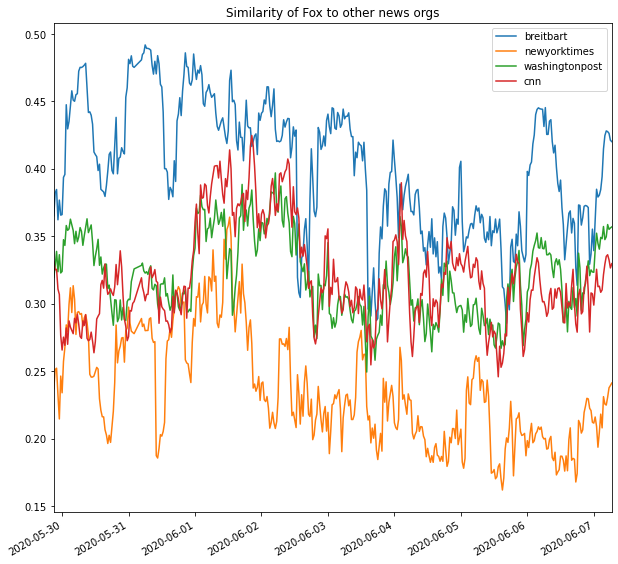

In [ ]:
fig, ax=plt.subplots(figsize=(10,10), facecolor="w")
foxsims.T.plot(title="Similarity of Fox to other news orgs", ax=ax)
plt.show()

## Similarity of coverage to lagged coverage o other publications

In [ ]:
#export
class describer(describer):
    "upgrade describer with mSOT"
    
    def meanSimilarityOverTime(self, endogenous:str, exogenous:list, maxLag=24, timeFrame=240):
        "calcultes TFIDF for endo, each exo using TF for doc as a page and IDF over entire corpus"
        vectorizer = TfidfVectorizer(stop_words = self.stopwords, max_features=10000)
        vectorizer.fit(self.df.quickReplace)
        self.df.date = pd.to_datetime(self.df.date)

        recent_dates = sorted(self.df.date.unique())
        today = self.df.date.max()
        
        lags = pd.DataFrame()
        
        print("beginning loops")
        
        for lag in range(maxLag):
            print(lag)
            cosims = pd.DataFrame()
            for i in range(1,timeFrame+1):
                try:
                    endo = vectorizer.transform(self.df[(self.df.source==endogenous) & (self.df.date == recent_dates[-i])].quickReplace).sum(axis=0)
                    for exoPub in exogenous:
                        exog = vectorizer.transform(self.df[(self.df.source==exoPub) & (self.df.date == recent_dates[-(i+lag)])].quickReplace).sum(axis=0)
                        cosims.at[recent_dates[-i], exoPub] = cosine_similarity(endo, exog)
                except:
                    pass
            for exoPub in exogenous:
                lags.at[lag, exoPub] = cosims[exoPub].mean()
            self.lags = lags        #for testing purposes
                
        return lags


In [ ]:
test2 = describer()
test2.load_article_holder(test)
rslts = test2.meanSimilarityOverTime("cnn", ["washingtonpost", "newyorktimes", "foxnews"])




beginning loops
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23


In [ ]:
test2.lags

,washingtonpost,newyorktimes,foxnews
0,0.410575,0.257027,0.312993
1,0.410247,0.257026,0.313584
2,0.409888,0.256908,0.313642
3,0.409448,0.256669,0.313560
4,0.409036,0.256428,0.313624
5,0.408762,0.256138,0.313762
6,0.408484,0.255547,0.313489
7,0.407929,0.254841,0.313238
8,0.407371,0.254273,0.312827
9,0.407043,0.253847,0.312627


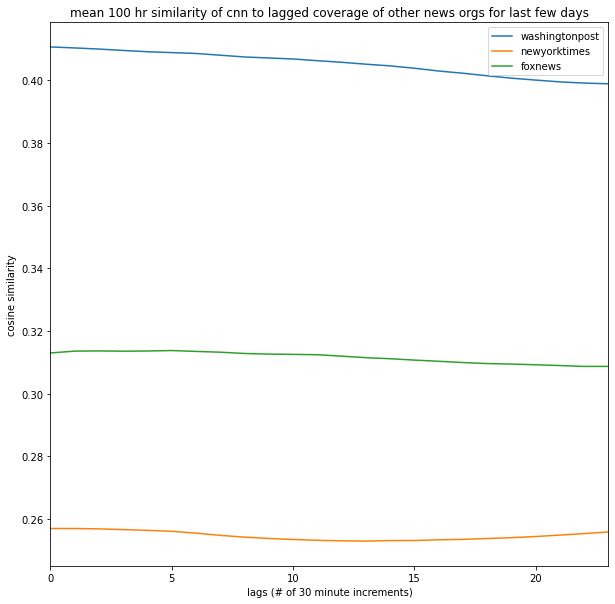

In [ ]:
fig, ax=plt.subplots(figsize=(10,10), facecolor="w")
test2.lags.plot(title="mean 100 hr similarity of cnn to lagged coverage of other news orgs for last few days", ax=ax)
ax.set_ylabel("cosine similarity")
ax.set_xlabel("lags (# of 30 minute increments)")
plt.show()

In [ ]:
#export
import multiprocessing
from gensim.models import Word2Vec
from time import time
import os
import math

# Training word2vec; make sure you have a c compiler installed or this can take a while

In [ ]:
#export
class describer(describer):
    "upgrade describer with word2vec"
    
    def word2vec(self, path=".", fileName=""):
        
        train = self.df.drop_duplicates(subset="quickReplace")
        
        model = Word2Vec(size=100, workers=multiprocessing.cpu_count()-1)
        model.build_vocab(train.tokens)
        model.train(train.tokens, total_examples=model.corpus_count, epochs=model.epochs)
        
        if fileName != "":
            os.makedirs(path, exist_ok=True)
            model.save("{}/{}.model".format(path, fileName))
        
        self.w2v = model
        return model


In [ ]:
test = describer()
test.set_articleDir(path="../CoverageTrends")
test.load_articles()

In [ ]:
test2 = describer()
test2.load_article_holder(test)
model = test2.word2vec(path="models", fileName="20200608_test")

In [ ]:
model.most_similar(positive=["coronavirus"])

/Library/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('covid', 0.9619004726409912),
 ('virus', 0.9212729930877686),
 ('cancer', 0.6089539527893066),
 ('result', 0.5791170597076416),
 ('confidenti', 0.5664907693862915),
 ('hydroxychloroquin', 0.556360125541687),
 ('diseas', 0.5441311597824097),
 ('studi', 0.5348715782165527),
 ('risen', 0.5290953516960144),
 ('pandem', 0.5281035304069519)]

In [ ]:
class describer(describer):
    "load w2v model"
    def loadw2v(self, model):
        self.w2v=model

## Compare docs; not sure how well this works on entire front page

In [ ]:
class describer(describer):
    "add getting w2v value"
    
    def getw2vvector(self, word):
        try:
            return self.w2v.wv[word]
        except:
            return 0


In [ ]:
class describer(describer):
    "compare cosine between vectors using one of the modelds"
    
    def w2vCosineSimilarity(self, list1, list2):
        "assumes a and b are pd.datafames of tokens (lists of lists)"
        
        a = [x for y in list1 for x in y]
        b = [x for y in list2 for x in y]

        firstVector = sum([self.getw2vvector(x) for x in a])
        secondVector = sum([self.getw2vvector(x) for x in b])
        
        return (self.w2v.wv.cosine_similarities(firstVector, [secondVector]))[0]

In [ ]:
test2 = describer()
test2.loadw2v(model)

In [ ]:
assert math.isclose(test2.w2v.wv.similarity("covid", "coronavirus"), test2.w2vCosineSimilarity([["covid"]], [["coronavirus"]]), rel_tol=.01)



In [ ]:
#export
class describer(describer):
    "update describer with similarity of w2v"
    
    def w2vSimilarityOverTime(self, endogenous:str, exogenous:list=[], lastNScrapes:int=6, scope=10):
        "caluculate w2v similar to publisher"
        

        if type(self.getw2vvector("covid")) == int:
            raise Exception ("no w2v model")
            
        
        self.df.date = pd.to_datetime(self.df.date)

        recent_dates = sorted(self.df.date.unique())
        today = self.df.date.max()
        
        cosims = pd.DataFrame()
        
        for i in range(1,scope+1):
            df = self.df[self.df.date == recent_dates[-i]]
            
            for exo in exogenous:
                cosims.at[exo, recent_dates[-i]] = self.w2vCosineSimilarity(df[df.source==endogenous].tokens, df[df.source==exo].tokens)
        #for testing purposes
        self.cosims = cosims
        return cosims


In [ ]:
test2 = describer()
test2.load_article_holder(test)
test2.loadw2v(model)
testSOT = test2.w2vSimilarityOverTime("cnn", ["washingtonpost", "newyorktimes", "foxnews"])

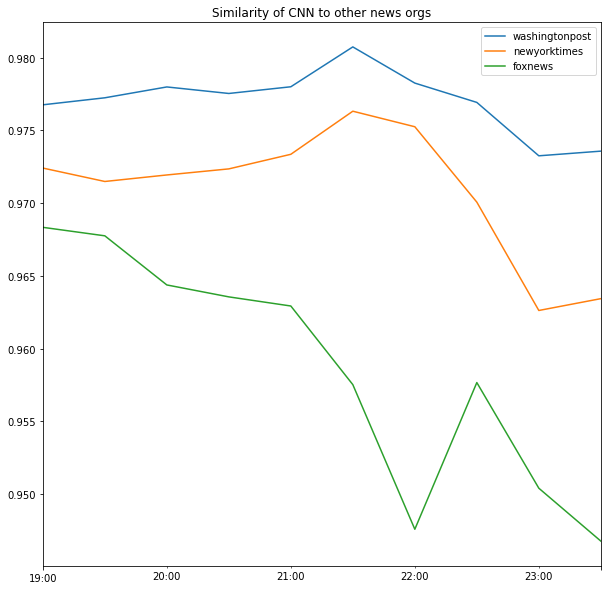

In [ ]:
fig, ax=plt.subplots(figsize=(10,10), facecolor="w")
testSOT.T.plot(title="Similarity of CNN to other news orgs", ax=ax)
plt.show()